# Elwha River Offset Arial Photo Matching

## Summary

In this chapter we outline an approach for matching misaligned cross-modal image datasets and apply the techniques to the Elwha river 2012 aerial dataset. The tutorial is styled with the primary goal of reproducibility and adaptability to similar use cases. The basic outline of the process is as follows:

1. Load the data and save the RGB and IR image files to a folder for ease of use
2. Stitch the RGB images together such that for each IR file we have one stitch image it fully overlaps
3. Estimate a homography that projects the IR image to its matched RGB stitch
4. Use this homography to create a mask that extracts only the overlapping portion of the RGB stitch
5. Cut the RGB stitches to create the final reconstructions

The entire workflow can be run with either the [full dataset](https://www.dropbox.com/s/qkr9712m8jt3zft/AirborneData.mat?dl=0) or with the minified version included in the Github repository. If you'd like to test out the workflow without cloning it onto your local machine, try Binder or Colab:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/StefanTodoran/elwha_dataset_realignment/HEAD)
[![Open in Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StefanTodoran/elwha_dataset_realignment)

## Getting Started

In this section, we do the necessary set up to be able to begin processing our dataset, including module imports and saving image data.

In [2]:
# If running on colab
# !pip install stitching
# !git clone https://github.com/StefanTodoran/elwha_dataset_realignment.git

In [2]:
import numpy as np
import os.path

from PIL import Image as im
import matplotlib.pyplot as plt

import cv2
import stitching
import scipy.io

# If running on colab:
# import sys
# sys.path.insert(1, 'elwha_dataset_realignment/book/chapters')
import util

In [3]:
airborne_data_path = "../data/Elwha2014.mat"
assert os.path.exists(airborne_data_path)
util.initializeFolders()

Loading the massive `mat` file takes a while so we place it in its own code cell.

In [4]:
airborne_data = scipy.io.loadmat(airborne_data_path)

Let's take a look at the keys.

In [5]:
airborne_keys = list(airborne_data.keys())
print(airborne_keys)

['__header__', '__version__', '__globals__', 'tempRiver', 'imageIR', 'altitude', 'datePDT', 'eastings', 'northings', 'Xt', 'Yt', 'Zt', 'maskRiver', 'timeEO', 'imageEO']


Looks like we have our images under 'imageRGB' and 'imageIR'.
Examining the format will help us figure out how to use the data.

In [7]:
raw_images = airborne_data[airborne_keys[12]]
print(type(raw_images))
print(raw_images.shape)
num_images = raw_images.shape[2]

<class 'numpy.ndarray'>
(480, 640, 393)


For some reason, the format the images are stored in seems to require us to index by the 3rd dimension.
The images are each 640x480 and 3 channel (RGB), and there are 406 in total.

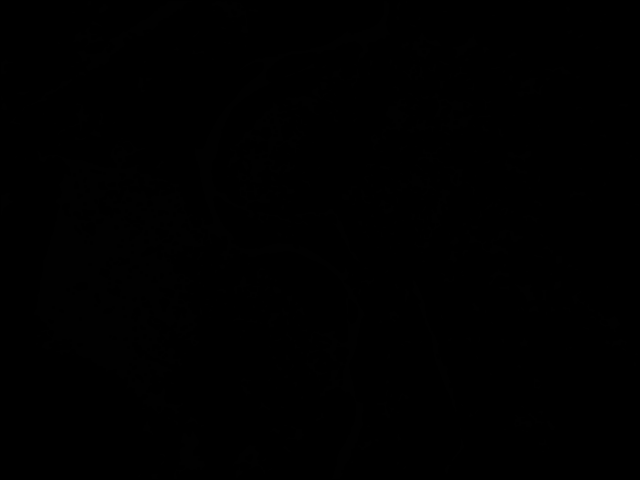

In [9]:
rgb_images = []
for x in range(num_images):
  image_data = im.fromarray(raw_images[:,:,x])
  rgb_images.append(image_data)
  image_data.save(f"../test/airborne_rgb_{x}.png")

display(rgb_images[10])

In [9]:
raw_ir_images = airborne_data[airborne_keys[4]]
print(type(raw_ir_images))
print(raw_ir_images.shape)
num_images = raw_ir_images.shape[2]

<class 'numpy.ndarray'>
(480, 640, 393)


Hmm... for some reason these images are sideways compared to the RGB ones. Also, pillow has trouble with this grayscale format so we are going to have to save images with matplotlib. We will store the dimensions for later, so we know what we are aiming for.

(-0.5, 479.5, 639.5, -0.5)

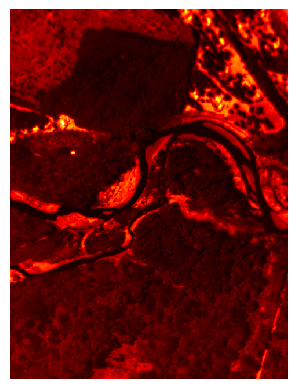

In [14]:
ir_images = []
for x in range(num_images):
  ir_image = np.rot90(raw_ir_images[:,:,x], -1, (0, 1))
  ir_images.append(ir_image)
  plt.imsave(f"../test/airborne_ir_{x}.png", ir_image, format="png", cmap="hot")

plt.imshow(ir_images[10], interpolation="none", cmap="hot")
plt.axis("off") # saved images won't look quite like this, as they won't have the white padding

## Stitching

The opencv image stitching pipeline is fairly complex. To simplify the process, we can use a python package based on opencv's stitching module, creatively called `stitching`.

The first step is to set up our stitcher object. Since we know that our dataset consists of terrain view from above, we want our stitches to remain as close to this as possible, that is, they should be as "flat" as possible. This immediately should indicate that the `mercator` and `transverseMercator` warpers are our best bet, and in fact some quick experimentation revealed transverseMercator to be the best for keeping the distortion in our panorama to a minimum.

In [11]:
settings = {"warper_type": "transverseMercator", "crop": False}
stitcher = stitching.Stitcher(**settings)

Stitching failed for the following images:
 [35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 57, 57, 58, 58, 59, 59, 60, 60, 61, 61, 62, 62, 63, 63, 64, 64, 65, 65, 66, 66, 67, 67, 68, 68, 69, 69, 70, 207, 208, 248, 249, 267, 268, 282, 283, 294, 295, 310, 311, 342, 343, 358, 359, 359, 360, 375, 376, 385, 386, 394, 395, 399, 400, 402, 403, 403, 404, 404, 405, 405, 406]
Resulting dataset loss: 12.81%


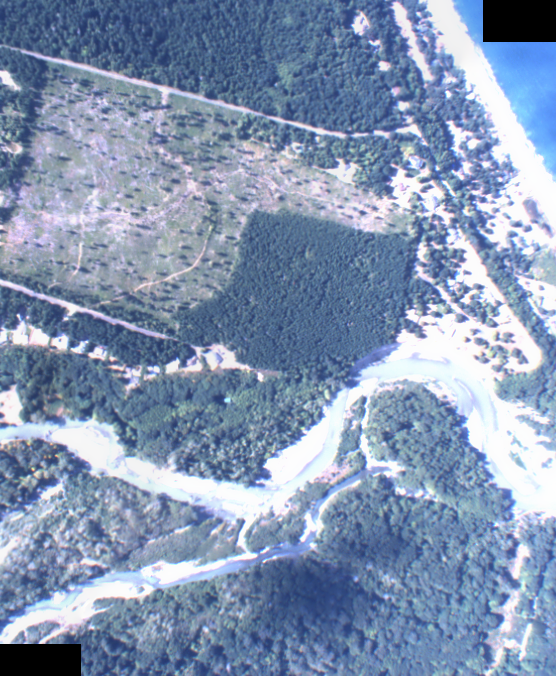

In [12]:
failed = []
for x in range(num_images - 1):
	
  try:
    stitched = stitcher.stitch([util.getSavePath("RGB", x), util.getSavePath("RGB", x + 1)])
    cv2.imwrite(util.getSavePath("STITCH", x), stitched)
  except:
    failed.append(x+1)
    failed.append(x+2)

print(f"Stitching failed for the following images:\n", failed)
print(f"Resulting dataset loss: {util.percentage(len(failed) / 2, num_images)}%")
im.open(util.getSavePath("STITCH", 0))

Stitching will fail for some number of the images. Unfortunately, if there aren't enough keypoints in the images there isn't much we can do. We will simply have to remove these images (and their associated IR images) from our dataset.

Although a loss of rougly `12%` may seem high, if we examine the images our stitching failed on, it seems a full `8%` aren't even images of the elwha river (#34 - #70) but rather images taken when the plane was turning around. Some of the later fails occur as the plane is descending and the image quality is poorer, as well as further inland where the area is more forested and there are less quality keypoints.

Moving on, here we can see that the first infrared image aligns with the first and second RGB images. Given that the misalignment factor between IR and RGB images is constant (they were attached to the same plane, just at different angles), this means for any IR image `x` we match it with RGB images `x` and `x + 1`. This means we can match every IR image fully with the exception of the first IR image.

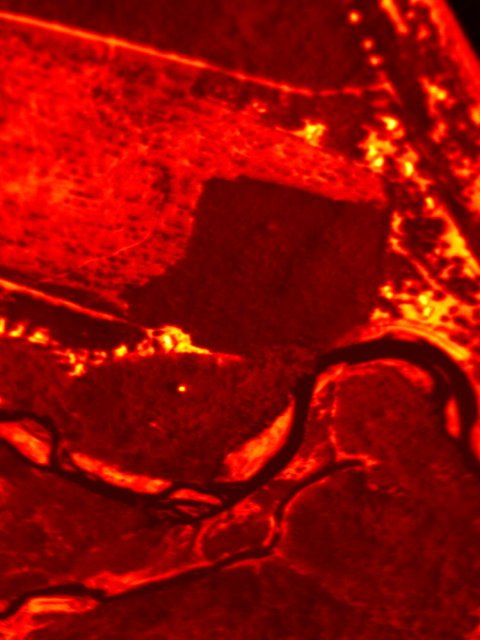

In [13]:
im.open(util.getSavePath("IR", 1))

## Matching

Now, we have to figure out what kind of descriptors we are going to use to figure out the alignment of the IR and RGB images. For a dataset where it is not as immediately obvious which images overlap with which and eyeballing it isn't going to cut it, the application of keypoints and descriptors could be used to match the images, but we will only be using them to figure out how to crop the stitched RGB images.

In [14]:
im_rgb = cv2.imread(util.getSavePath("STITCH", 0))[:,:,::-1] # opencv reads BGR so we use this notation to reverse the order
im_ir = cv2.imread(util.getSavePath("IR", 1), cv2.IMREAD_GRAYSCALE)

6607 RGB keypoints, 403 IR keypoints
263 matches found


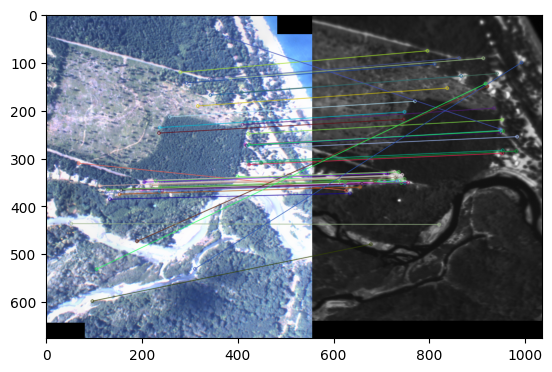

In [15]:
# Initiate BRISK detector
brisk = cv2.BRISK_create()

# find the keypoints and descriptors with BRISK, no mask
kp1, des1 = brisk.detectAndCompute(im_rgb, None)
kp2, des2 = brisk.detectAndCompute(im_ir, None)
print(f"{len(kp1)} RGB keypoints, {len(kp2)} IR keypoints")

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)
print(len(matches), "matches found")

# Sort them in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)
matches = matches[:50]

vis = cv2.drawMatches(im_rgb, kp1, im_ir, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(vis)
plt.show()

It seems ORB descriptors don't do a half bad job, however BRISK descriptors seem to very slightly outperform them here (ORB trial not shown). This makes sense as BRISK has lower variance in response to photometric changes like illumination compared to ORB, which excels at geometric changes. According to [this](https://arxiv.org/ftp/arxiv/papers/2012/2012.04135.pdf) paper however, KAZE and AKAZE should outperform BRISK for photometric changes (1). In fact, the paper claims KAZE and AKAZE are most invariant to photometric changes out of all opencv detectors and descriptors!

Granted, the paper is testing this via variance in response to illumination, blur, and compression. I was unable to find much in the literature with regards to which detectors and descriptors perform best in matching across colorspaces, as most techniques which tackle this problem use neural networks (2, 3). 

2276 RGB keypoints, 385 IR keypoints
211 matches found


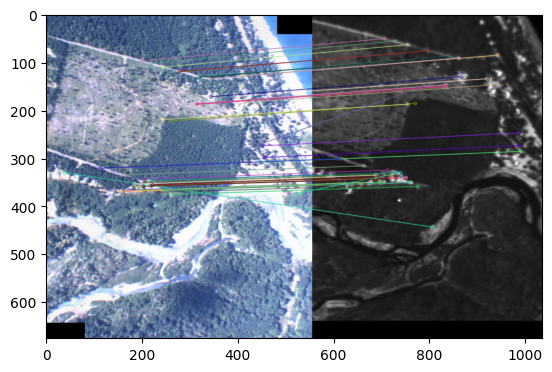

In [16]:
# Initiate AKAZE detector
akaze = cv2.AKAZE_create()

# find the keypoints and descriptors with BRISK
kp1, des1 = akaze.detectAndCompute(im_rgb, None)
kp2, des2 = akaze.detectAndCompute(im_ir, None)
print(f"{len(kp1)} RGB keypoints, {len(kp2)} IR keypoints")

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)
print(len(matches), "matches found")

# Sort them in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)
matches = matches[:50]

vis = cv2.drawMatches(im_rgb, kp1, im_ir, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(vis)
plt.show()

From this simple test, this seems to be the case, with AKAZE only having ~4 erroneous matches in the top 50 best matches, compared to BRISK's ~12 erroneous matches. (No need to count by hand to verify which is better, see the output from the match filtering later in this section).

We can do further corrections however, as our knowledge of how the matches should look can allow us to filter out erroneous keypoints in a way that keypoint distance alone cannot. Specifically, we know something in the top right of the IR image probably shouldn't be matching with something in the bottom left of the RGB image. Before we implement this, let's finalize our keypoint matching code:

In [17]:
def findAndMatchKeypoints(im_rgb, im_ir):
  # Initiate AKAZE detector, find the keypoints and descriptors with BRISK
  akaze = cv2.AKAZE_create()
  kp1, des1 = akaze.detectAndCompute(im_rgb, None)
  kp2, des2 = akaze.detectAndCompute(im_ir, None)

  # create BFMatcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

  # Match descriptors and sort by distance
  matches = list(bf.match(des1, des2))
  
  # matches = sorted(matches, key = lambda x:x.distance)
  # matches = matches[:100]

  return kp1, kp2, matches

By examining our matched image from before with image quadrants shown, we can see that outliers are matches where the keypoints fall in different quadrants in their respective images. The only exception to this may be keypoints very near the center (in either x or y), so we can add an exception for these and only care about quadrant for points that are distant enough from their respective image centers.

![Quadrant Filtering](../img/quadrants.png)

In [18]:
center_threshold = 0.04

def filterBadMatches(keypoints1, keypoints2, imagesize1, imagesize2, matches):
  remove = set()
  dx = []
  dy = []

  i = 0
  for match in matches: # cross quadrant filtering
    rgb_pt = keypoints1[match.queryIdx].pt
    ir_pt = keypoints2[match.trainIdx].pt

    dx.append(rgb_pt[0] - ir_pt[0])
    dy.append(rgb_pt[1] - ir_pt[1])

    if (not util.getQuadrant(rgb_pt, imagesize1) == util.getQuadrant(ir_pt, imagesize2) and 
      (not util.isNearCenter(rgb_pt, imagesize1, center_threshold) or not util.isNearCenter(ir_pt, imagesize2, center_threshold))):
      remove.add(i)

    i += 1

  dx_threshold = imagesize1[1] / 4
  dy_threshold = imagesize1[0] / 4
  median_dx = np.median(dx)
  median_dy = np.median(dy)

  i = 0
  for match in matches: # difference deviation filtering
    rgb_pt = keypoints1[match.queryIdx].pt
    ir_pt = keypoints2[match.trainIdx].pt

    dx = rgb_pt[0] - ir_pt[0]
    dy = rgb_pt[1] - ir_pt[1]

    if not util.withinThresholdDeviations(dx, dx_threshold, median_dx) or not util.withinThresholdDeviations(dy, dy_threshold, median_dy):
      remove.add(i)

    i += 1

  for i in sorted(remove, reverse=True):
    if len(matches) > 4:
      del matches[i]

  return len(remove)

Another method that can be used to further narrow down which keypoints are kept in addition to the removal of cross quadrant points is the removal of points which deviate by too much from the median RGB to IR dx and dy. Looking at the matches visualized with `cv2.drawMatches`, we can see that since the IR image and the RGB image are off the same terrain, the inliers all share roughly the same change in x and change in y. Therefore, we can compute the median `dx` and `dy` values, and remove points which deviate to far from the baseline in a second pass. 

Let's verify how well our function is working at removing outliers.

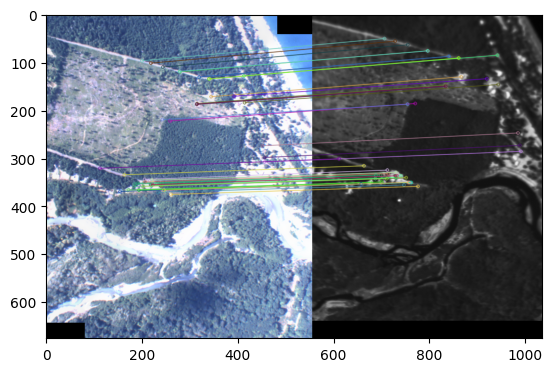

Removed 3 bad matches.


In [19]:
bad = filterBadMatches(kp1, kp2, im_rgb.shape, im_ir.shape, matches)
vis = cv2.drawMatches(im_rgb, kp1, im_ir, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(vis)
plt.show()
print(f"Removed {bad} bad matches.")

## Mapping Prep

Its time for the meat of the alignment process, namely estimating the homographies that would map the IR images to the RGB stitches' coordinate spaces, and then using this projection to create a mask. However, before we get started we need to do some preparation.

The way `BFMatcher` works is that it returns to us a list of `cv2.DMatch` objects. Each of these objects has a `queryIdx` and `trainIdx` attribute. These correspond to the index in kp1 and kp2 which the match represents, respectively. Therefore we can obtain the image coordinates of the matches with the following code.

In [20]:
def compileMatchedCoords(keypoints1, keypoints2, matches):
  rgb_coords = []
  ir_coords = []

  for match in matches:
    rgb_kp_index = match.queryIdx
    ir_kp_index = match.trainIdx

    rgb_coords.append(keypoints1[rgb_kp_index].pt)
    ir_coords.append(keypoints2[ir_kp_index].pt)

  return (rgb_coords, ir_coords)

Next, lets create a function that turns all black pixels transparent, and another for inverting colors (used for masks which only have black and white portions, that way we don't need a whiteToTransparent function too). These will be useful when masking portions of the stitched RGB images later.

In [21]:
def blackToTransparent(path, thresh=0):
  img = cv2.imread(path) # load as np array, BGR
  alpha = np.sum(img, axis=-1) > thresh # boolean mask of sum over BGR
  alpha = np.uint8(alpha * 255) # uint8 to make imread

  res = np.dstack((img, alpha))
  cv2.imwrite(path, res)

def colorInvert(path):
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED) # load as np array, BGR
  
  b, g, r, a = cv2.split(img)
  b = np.invert(b)
  g = np.invert(g)
  r = np.invert(r)
  inv = cv2.merge([b, g, r, a], 4)

  cv2.imwrite(path, inv)

With our helper methods out of the way, we can write our homography estimation code. Since this funciton abstracts the keypoints and matches away completely, we can tuck the matches visualization in here as well under an optional path parameter.

In [22]:
def getHomography(im_rgb, im_ir, save_matches=""):
  kp1, kp2, matches = findAndMatchKeypoints(im_rgb, im_ir)
  bad = filterBadMatches(kp1, kp2, im_rgb.shape, im_ir.shape, matches)
  rgb_coords, ir_coords = compileMatchedCoords(kp1, kp2, matches)
  homography, status = cv2.findHomography(np.array(ir_coords), np.array(rgb_coords), cv2.RANSAC, 7.5)

  if not save_matches == "":
    vis = cv2.drawMatches(im_rgb, kp1, im_ir, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imsave(save_matches, vis, format="png")

  return homography

## Quality Control

This part is the most informal part of the workflow, but is a useful step and one that is difficult to automate and abstract away. Two cells below, under the `Mapping` section, we put it all together, with a loop over all our images which projects and then pastes each IR image onto its corresponding RGB stitch.

We need to run that code to generate all of the matched images. Then, we need to go through the images by hand and select a baseline homography. This should be an image that is transformed and matched in a way that will be similar to much of the dataset. Finally, by looking through the input we need to select some appropriate thresholds. This can be done by manually searching through the images and manually picking thresholds based on the differences in values for good and poor matches.

You may also need to modify `center_threshold`, `dx_threshold`, and `dy_threshold` in the match filtering code from earlier. The homography related thresholds determine which homographies are considered "bad" and excluded from the final reconstructed dataset, while the thresholds in the match filtering code directly affect how good the homographies actually are.

This is a fairly subjective process, but in essence it can be done via trial and error, running the workflow with certain values and examining if there are any outputs that are very poor reconstructions. If there are, we need to examine the associated homography and bounds to re-evaluate our thresholds.

In [23]:
standard = np.array([
  [8.8e-01, -1.0e-03, 6.0e+01],
  [-1.0e-02, 8.8e-01, 5.5e+01],
  [-5.0e-05, 0.0, 1.0e+00],
])
identity = np.array([
  [1, 0, 0],
  [0, 1, 0],
  [0, 0, 1],
])
standard_rototation, standard_translation, standard_normal  = util.unTuple(cv2.decomposeHomographyMat(standard, identity))

Obviously the values have already been determined and are in the cell above and the cell below. However, the described process is useful for understanding where these values came from.

In [24]:
homography_threshold = 150
rotation_threshold = 0.5
translation_threshold = 300
normal_threshold = 0.5

def isOutlier(homography):
  rototation, translation, normal = util.unTuple(cv2.decomposeHomographyMat(homography, identity))

  return (
    util.distance(homography, standard) > homography_threshold or
    util.distance(rototation, standard_rototation) > rotation_threshold or
    util.distance(translation, standard_translation) > translation_threshold or
    util.distance(normal, standard_normal) > normal_threshold
  )

Use this code in the `isOuterlier` function when tinkering with thresholds:

In [25]:
# print("\nhomography distance", util.distance(homography, standard), util.distance(homography, standard) > homography_threshold)
# print("rotation distance: ", util.distance(rototation, standard_rototation), util.distance(rototation, standard_rototation) > rotation_threshold)
# print("translation distance: ", util.distance(translation, standard_translation), util.distance(translation, standard_translation) > translation_threshold)
# print("normal distance: ", util.distance(normal, standard_normal), util.distance(normal, standard_normal) > normal_threshold)

## Mapping

This code maps IR images to their RGB stitches in the same way that masks will be projected, but it is easier to visually confirm the quality of a projection in this form.

Poor matches found for the following images: (note, poor quality for image x indicates match_x+1 is poor)
 [31, 32, 33, 69, 70, 72, 110, 137, 147, 150, 151, 163, 165, 167, 173, 175, 186, 207, 208, 209, 212, 214, 240, 243, 245, 248, 250, 264, 265, 267, 269, 270, 271, 284, 285, 286, 287, 291, 292, 295, 296, 297, 298, 302, 303, 304, 305, 306, 308, 325, 330, 332, 333, 334, 335, 336, 337, 339, 366, 381, 389]
Loss from ignored poor quality matches: 15.02%


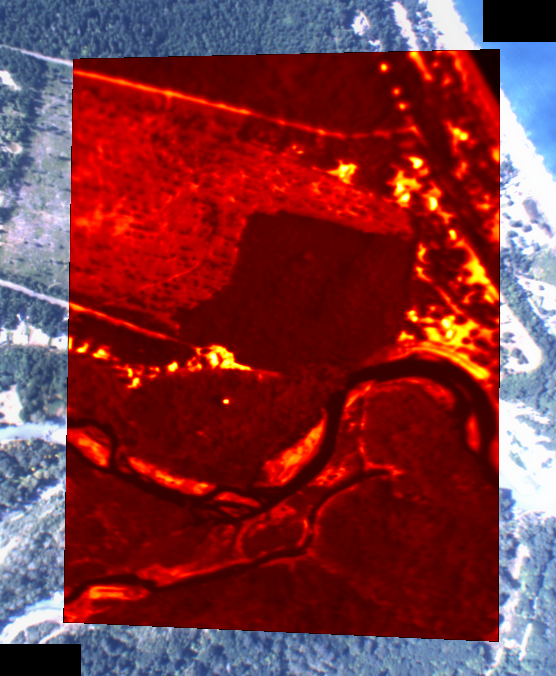

In [26]:
poor_quality = []
bad_matches = 0

for x in range(num_images - 1):
  rgb_path = util.getSavePath("STITCH", x)
  ir_path = util.getSavePath("IR", x + 1)
  match_path = util.getSavePath("MATCH", x)

  if (not os.path.exists(rgb_path) or not os.path.exists(ir_path)):
    continue

  im_rgb = cv2.imread(rgb_path)[:,:,::-1] # opencv reads BGR so we use this notation to reverse the order
  im_ir = cv2.imread(ir_path, cv2.IMREAD_GRAYSCALE)

  # Get our keypoints matched and into a usable for for the homography
  homography = getHomography(im_rgb, im_ir, save_matches=util.getSavePath("KEYPOINTS", x))

  if homography is None:
    poor_quality.append(x)
    continue

  # Warp source image to destination based on homography
  ir_warped = cv2.warpPerspective(im_ir, homography, (im_rgb.shape[1], im_rgb.shape[0]))

  # For some reason plt.imsave leaves some near black pixels around the edge, as opposed 
  # to completely black, so we set a higher threshold. We want just the projected IR image.
  plt.imsave(match_path, ir_warped, format="png", cmap="hot")
  blackToTransparent(match_path, 10)

  # We then paste this projected IR image onto our stitched RGB image.
  im_rgb = im.open(rgb_path, "r")
  ir_warped = im.open(match_path, "r")
  im_rgb.paste(ir_warped, (0, 0), ir_warped) # when pasting transparent image, 3rd parameter is mask (uses alpha channel)

  if (isOutlier(homography)):
    # print(f"Outlier detected for match {x+1}, marking as poor...")
    poor_quality.append(x)

  im_rgb.save(match_path)
  
print(f"Poor matches found for the following images: (note, poor quality for image x indicates match_x+1 is poor)\n", poor_quality)
print(f"Loss from ignored poor quality matches: {util.percentage(poor_quality, num_images)}%")
im.open(util.getSavePath("MATCH", 0))

Now, we need to repeat essentially the same workflow as above, except instead of projecting and pasting the IR image onto the RGB stitch, we want to use the same homograph but project and paste a mask onto a background, in order to generate a mask that can later be pasted onto the RGB stitch in order to crop it.

The mask should have the size of the IR image, and the background that of the RGB image.

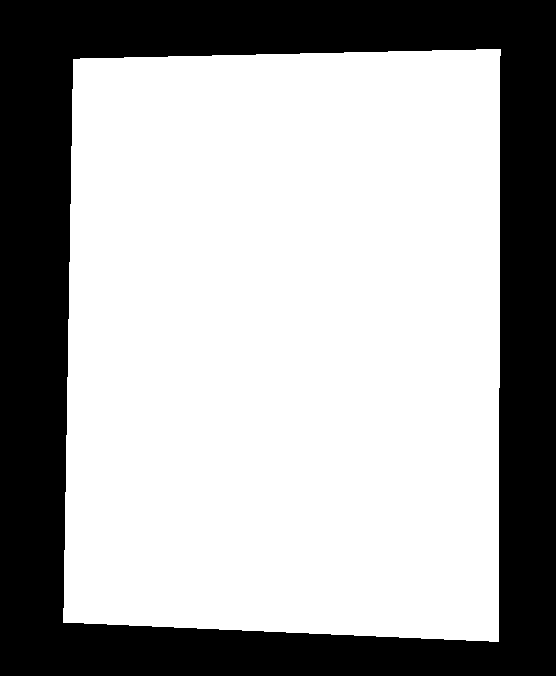

In [27]:
for x in range(num_images - 1):
  rgb_path = util.getSavePath("STITCH", x)
  ir_path = util.getSavePath("IR", x + 1)
  mask_path = util.getSavePath("MASK", x)

  if (not os.path.exists(rgb_path) or not os.path.exists(ir_path)):
    continue

  im_rgb = cv2.imread(rgb_path)[:,:,::-1] # opencv reads BGR so we use this notation to reverse the order
  im_ir = cv2.imread(ir_path, cv2.IMREAD_GRAYSCALE)
  homography = getHomography(im_rgb, im_ir)

  if homography is None:
    continue

  # Warp source image to destination based on homography
  mask = np.ones((im_ir.shape[0], im_ir.shape[1], 3), np.uint8) * 255
  mask_warped = cv2.warpPerspective(mask, homography, (im_rgb.shape[1], im_rgb.shape[0]))

  # we currently have a white rectange projected onto a black background. We need
  # to invert this so we can cut out the rectangle using blackToTransparent.
  plt.imsave(mask_path, mask_warped, format="png")
  colorInvert(mask_path)

  # Because of the rotation, some edge pixels are between black and white, we can just 
  # remove all of these, so we treat any non-fully white pixel as black. 255*3 - 1 = 764
  blackToTransparent(mask_path, 764)
  colorInvert(mask_path) # One final color invert since we always cut black pixels
  
im.open(util.getSavePath("MASK", 0))

With all our masks prepared, the final remaining step is to create a method that can extract our masked RGB data. We need to find our keypoints and homography again, this time so that we can project in the reverse direction. Then, once we cut away all the black pixels we can use the `getbbox` method to crop and resize such that only non-transparent pixels are left.

![Masking Workflow](../img/masking.png)

In [28]:
def cropFromMask():
  rgb_path = util.getSavePath("STITCH", x)
  mask_path = util.getSavePath("MASK", x)
  ir_path = util.getSavePath("IR", x + 1)
  final_path = util.getSavePath("FINAL", x)

  if (not os.path.exists(rgb_path) or not os.path.exists(mask_path) or not os.path.exists(ir_path)):
    return False

  np_rgb = cv2.imread(rgb_path)[:,:,::-1]
  im_ir = cv2.imread(ir_path, cv2.IMREAD_GRAYSCALE)
  im_rgb = im.open(rgb_path, "r")
  mask = im.open(mask_path, "r")
  
  homography = getHomography(np_rgb, im_ir)
  inv_homography = np.linalg.inv(homography)

  im_rgb.paste(mask, (0, 0), mask) # when pasting transparent image, 3rd parameter is mask (uses alpha channel)
  im_rgb.save(final_path)

  img = cv2.imread(final_path)
  img = cv2.warpPerspective(img, inv_homography, (np_rgb.shape[1], np_rgb.shape[0]))
  cv2.imwrite(final_path, img)

  blackToTransparent(final_path)

  # At this point, we should have the aligned section of the RGB image 
  # surrounded by transparent pixels, and it may be stretched or squeezed
  uncropped = im.open(final_path)
  cropped = uncropped.crop(uncropped.getbbox())
  cropped = cropped.resize((480, 640))
  cropped.save(final_path)

  return True

## Results

With the code below we can generate our final realigned RGB images. Homographies labeled as poor quality in the prior projection loop are ignored. The RGB reconstructions will vary in quality, with some being perfect matches and others being less aligned or even having some small gaps with no pixel data.

If these lower quality matches are a large issue, return to the `Quality Control` section and make the thresholds for determining substandard homographies more stringent.

Successfully realigned 344 images.
Percentage of total dataset realigned: 84.73%


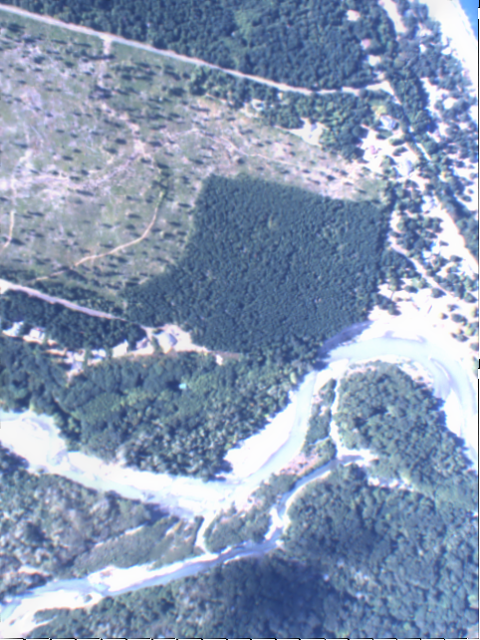

In [29]:
count = 0
for x in range(num_images - 1):
  if x not in poor_quality:
    cropFromMask()
    count += 1
  
print(f"Successfully realigned {count} images.")
print(f"Percentage of total dataset realigned: {util.percentage(count, num_images)}%")
im.open(util.getSavePath("FINAL", 0))